In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as nnf
import torchvision
from torchvision import datasets, models, transforms

import os
import numpy as np
import random

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from torch.autograd import Variable

import cv2
import imutils

import math

BCK_COLOR = (255, 255, 255) # (255, 255, 255) WHITE

In [6]:
model_load_path = 'models/ptah.pth'
num_channels = 3

data_dir = 'data' 
template_dir = '../template_images'

trained_signs = np.load('class_names.npy')
trained_signs.sort()

num_signs = len(trained_signs)

print('Signs in the trained model:',trained_signs)

Signs in the trained model: ['A1' 'A21' 'A30' 'A40' 'AA1' 'D21' 'D28' 'D35' 'D36' 'D37' 'D46' 'D58'
 'F31' 'F32' 'F35' 'G1' 'G17' 'G26' 'G36' 'G36A' 'G38' 'G39' 'G43' 'H6'
 'I10' 'I9' 'L1' 'M17' 'M40' 'M5' 'N16' 'N17' 'N29' 'N35' 'N37' 'N5' 'O4'
 'Q3' 'R11' 'R8' 'S29' 'S34' 'S40' 'T34' 'T35' 'U36' 'V13' 'V28' 'V30'
 'V31' 'W11' 'X1' 'X8' 'Y1' 'Y3' 'Y5' 'Z1' 'Z4' 'ZZ1']


In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 1000)
        self.fc2 = nn.Linear(1000, 128)
        self.fc3 = nn.Linear(128, num_signs)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))   
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# OCR test dataset
data_transforms = {
'train': transforms.Compose([
    transforms.Resize([32, 32]),        
    transforms.Grayscale(num_channels),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),    
'ocr': transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.Grayscale(num_channels),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),    
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                    data_transforms[x])
            for x in ['ocr']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                        shuffle=True, num_workers=4)
            for x in ['ocr']}

print('Signs in the OCR Dataset:',image_datasets['ocr'].classes)
ocr_classes = image_datasets['ocr'].classes

# ocr_classes = ocr_classes.sort()
# print('Sings in the OCR Dataset:',image_datasets['ocr'].classes)


Signs in the OCR Dataset: ['AA1', 'D21', 'D36', 'D46', 'D58', 'F32', 'G1', 'G17', 'G43', 'I10', 'I9', 'M17', 'N29', 'N35', 'N37', 'O4', 'Q3', 'S29', 'V13', 'V28', 'V31', 'W11', 'X1']


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net()

if torch.cuda.is_available():
    model.load_state_dict(torch.load(model_load_path))
else:
    model.load_state_dict(torch.load(model_load_path, map_location=torch.device('cpu')))

if torch.cuda.is_available():  
    model.cuda()

model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=59, bias=True)
)

# 1. Single Image Classification demo
## Pick an image return it's Gardiner code

In [11]:

source_dir = os.path.join(data_dir,'ocr')

files = list()
for (dirpath, dirnames, filenames) in os.walk(source_dir):
    files += [os.path.join(dirpath, file) for file in filenames]

print(files)

# Pick a random file
filename = random.choice(files)

print(filename)

ground_truth_sign = os.path.basename(filename)
ground_truth_sign = ground_truth_sign.split('_')[0].split('.')[0]

with torch.no_grad():
    img = Image.open(os.path.join(filename))

    img_tensor = data_transforms['ocr'](img)
    img_tensor.unsqueeze_(0)

    if torch.cuda.is_available():            
        img_tensor = img_tensor.to(device)  

    outputs = model(img_tensor)
    _, preds = torch.max(outputs,1)

    sign = trained_signs[preds].upper()  

    # Show output
    template_filename = sign+'_AbydosB_200_crop.jpg'
    template_file = os.path.join(template_dir,template_filename)
    template_img = Image.open(template_file)

    template_filename = ground_truth_sign+'_AbydosB_200_crop.jpg'
    template_file = os.path.join(template_dir,template_filename)
    ground_truth_sign_img = Image.open(template_file)

    fig,axs = plt.subplots(1,3,figsize=(6,8))
    axs[0].imshow(img)
    axs[0].set_title(filename)
    axs[1].imshow(ground_truth_sign_img.resize((32,32)))
    axs[1].set_title('Ground truth:'+ground_truth_sign)    
    axs[2].imshow(template_img.resize((32,32)))
    axs[2].set_title('Predicted sign:'+sign)
    plt.show(block=True)  


    # Print top 3 classes with respective probabilities
    probs = nnf.softmax(outputs, dim=1).cpu().numpy()[0]
    top3_pred_idxs = probs.argsort()[-3:][::-1]
 
    for i in range(0,len(top3_pred_idxs)):
        _idx = top3_pred_idxs[i]
        _sign = trained_signs[_idx]
        _prob = probs[_idx]
        print("%s %0.2f%%"%(_sign,_prob*100))

['data/ocr/AA1/Aa1.png', 'data/ocr/AA1/AA1_AaronUMdCAlpha100.jpg', 'data/ocr/AA1/AA1_Aegyptus.jpg', 'data/ocr/AA1/AA1_Code2003-egdm.jpg', 'data/ocr/AA1/AA1_JSeshFont.jpg', 'data/ocr/AA1/Aa1_mereruka1.png', 'data/ocr/AA1/Aa1_mereruka2.png', 'data/ocr/AA1/AA1_NewGardinerSMP.jpg', 'data/ocr/AA1/AA1_NotoSansEgyptianHieroglyphs-Regular.jpg', 'data/ocr/AA1/Aa1_s.png', 'data/ocr/AA1/Aa1_s1.png', 'data/ocr/AA1/Aa1_s2.png', 'data/ocr/AA1/AA1_seguihis.jpg', 'data/ocr/AA1/Aa1_unas.png', 'data/ocr/D21/D21.png', 'data/ocr/D21/D21_mereruka2.png', 'data/ocr/D21/D21_mereruka3.png', 'data/ocr/D21/D21_s.png', 'data/ocr/D21/D21_s1.png', 'data/ocr/D21/D21_s2.png', 'data/ocr/D36/D36.png', 'data/ocr/D36/D36_mereruka2.png', 'data/ocr/D36/D36_mereruka4.png', 'data/ocr/D36/D36_s.png', 'data/ocr/D36/D36_s1.png', 'data/ocr/D36/D36_S2.png', 'data/ocr/D46/D46.png', 'data/ocr/D46/D46_mereruka1.png', 'data/ocr/D46/D46_mereruka2.png', 'data/ocr/D46/D46_mereruka5.png', 'data/ocr/D46/D46_mereruka7.png', 'data/ocr/D46/D

FileNotFoundError: [Errno 2] No such file or directory: '../template_images/D21_AbydosB_200_crop.jpg'

# 2. Multiple image Classification demo
## Pick a directory and return the Gardiner codes for all images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


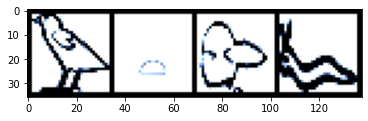

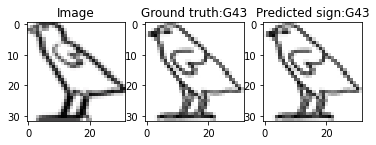

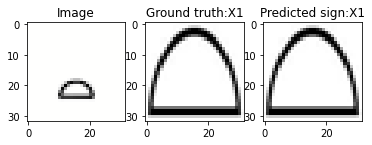

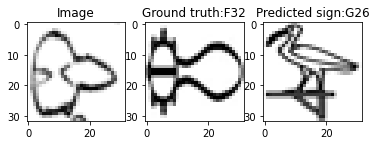

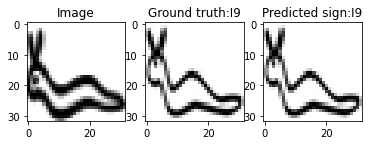

Ground Truth:    G43    X1   F32    I9
Predicted   :    G43    X1   G26    I9
Accuracy of the network on the test (OCR) images: 75 %


In [6]:
# functions to show an image
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

source_dir = os.path.join(data_dir,'ocr')


sign = os.path.basename(filename)
sign = sign.split('_')[0].split('.')[0]

correct = 0
total = 0

with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['ocr']):

        if torch.cuda.is_available():            
            inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        total += labels.size(0)
        
        imshow(torchvision.utils.make_grid(inputs))

        for idx in range(len(labels)):          
            iin = torchvision.utils.make_grid(inputs[idx])
            
            sign_idx = labels[idx].cpu().numpy()

            ground_truth_sign = ocr_classes[sign_idx].upper()

            template_filename = ground_truth_sign+'_AbydosB_200_crop.jpg'
            template_file = os.path.join(template_dir,template_filename)
            ground_truth_sign_img = Image.open(template_file)

            pred_sign = trained_signs[preds[idx].cpu().numpy()]
            template_filename = pred_sign+'_AbydosB_200_crop.jpg'
            template_file = os.path.join(template_dir,template_filename)            
            predicted_img = Image.open(template_file)

            if pred_sign == ground_truth_sign:
                correct += 1

            im = iin.cpu().numpy()
            im = np.transpose(im, (1, 2, 0))
            # normalize
            for i in range(num_channels):
                minval = im[...,i].min()
                maxval = im[...,i].max()
                if minval != maxval:
                    im[...,i] -= minval
                    im[...,i] *= (255.0/(maxval-minval))
         
            img = Image.fromarray(np.uint8(im))

            fig,axs = plt.subplots(1,3,figsize=(6,8))
            axs[0].imshow(img)
            axs[0].set_title("Image")
            axs[1].imshow(ground_truth_sign_img.resize((32,32)))
            axs[1].set_title('Ground truth:'+ground_truth_sign)    
            axs[2].imshow(predicted_img.resize((32,32)))
            axs[2].set_title('Predicted sign:'+pred_sign)
            plt.show(block=True)    

        print('Ground Truth: ', ' '.join('%5s' % ocr_classes[labels[j]] for j in range(len(labels))))
        print('Predicted   : ', ' '.join('%5s' % trained_signs[preds[j]] for j in range(len(preds)))) 


        break      

print('Accuracy of the network on the test (OCR) images: %d %%' % (100 * correct / total)) 